# 천안정수장 원수 및 침전탁도

필요한 라이브러리 import

In [1]:
import streamlit as st
import pandas as pd
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import openpyxl

plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 출력된 다른 이름
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시, 마이너스 기호 깨짐 방지
%matplotlib inline


### 로그 변환할지 확인하기 위한 히스토그램 출력

In [ ]:
def check_to_log(df):
    # 로그 변환 대상 컬럼 리스트 (양수여야 함)
    columns_to_check = ['탁도', '약품주입율 계산']  # 필요시 다른 컬럼 추가

    # 히스토그램 출력
    for col in columns_to_check:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        
        # 원래 분포
        axs[0].hist(df[col].dropna(), bins=50, color='skyblue')
        axs[0].set_title(f'{col} - 원래 분포')
        
        # 로그 변환 분포
        log_data = df[col][df[col] > 0]  # 0 이하 제외
        log_data = np.log10(log_data)
        axs[1].hist(log_data.dropna(), bins=50, color='lightgreen')
        axs[1].set_title(f'{col} - 로그 변환 분포')

        plt.tight_layout()
        plt.show()

### 데이터 불러오기
### 및 데이터 전처리

In [26]:

# 데이터 불러오기
df = pd.read_csv('./data/CA_Water_Quality.csv', encoding="CP949", low_memory=False)

# df["로그 탁도"] = np.log10(df["탁도"])
# df["로그 응집제 주입률"] = np.log10(int(df["약품주입율 계산"]))
# np.log10은 데이터 전처리 후 사용


df.rename(columns={'약품주입율 계산': '약품주입율'}, inplace=True)


df = df[
    [
        "탁도",
        "pH",
        "알칼리도",
        "전기전도도",
        "수온",
        "유입유량",
        "침전탁도",
        "약품주입율"
    ]
]




In [27]:

# 두 컬럼만 숫자로 변환 (숫자가 아닌 값은 NaN으로 처리)
df['탁도'] = pd.to_numeric(df['탁도'], errors='coerce')
df['약품주입율'] = pd.to_numeric(df['약품주입율'], errors='coerce')

# 변환 후 NaN 확인 (비정상값이 있었는지 확인 가능)
print(df[['탁도', '약품주입율']].isna().sum())

# 탁도 0개, 약품주입율 계산 11개 데이터가 na로, 행 삭제

df = df.dropna(subset=['탁도', '약품주입율'])


탁도        0
약품주입율    11
dtype: int64


In [28]:
df.describe()

,탁도,pH,알칼리도,전기전도도,수온,유입유량,침전탁도,약품주입율
count,526970.000000,526970.000000,526970.000000,526970.00000,526970.000000,526970.000000,526970.000000,526970.000000
mean,31.184532,7.216701,30.193983,137.06379,14.891338,12005.192493,32.747157,22.972786
std,231.648163,0.828031,5.294893,22.13868,19.550480,1663.340725,341.258221,13.894182
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.880000,7.090000,26.660000,119.28000,9.170000,11095.000000,0.490000,13.000000
50%,2.600000,7.360000,32.210000,146.41000,13.550000,11996.000000,0.690000,16.000000
75%,12.870000,7.460000,33.880000,153.44000,21.860000,13047.000000,1.000000,35.000000
max,2755.000000,7.710000,41.490000,172.09000,7814.380000,142090.000000,4954.510000,92.000000


### 각 데이터별 시각화하여 이상치 확인

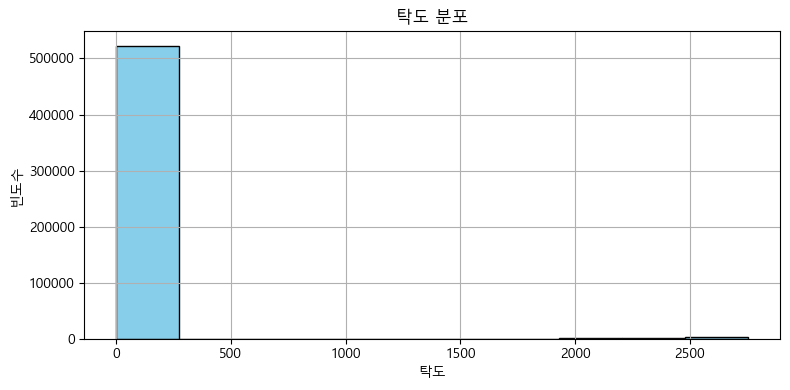

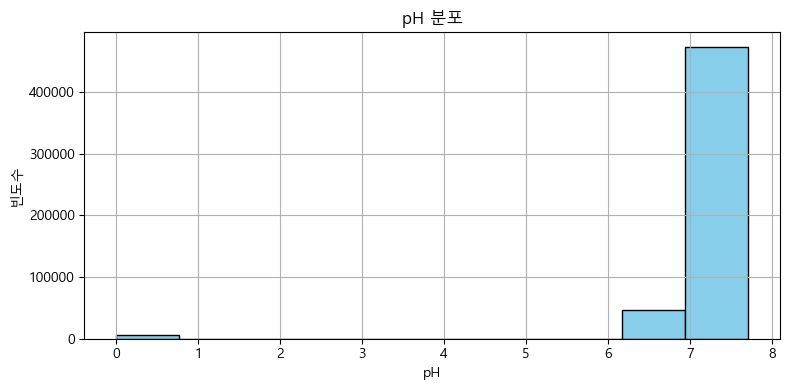

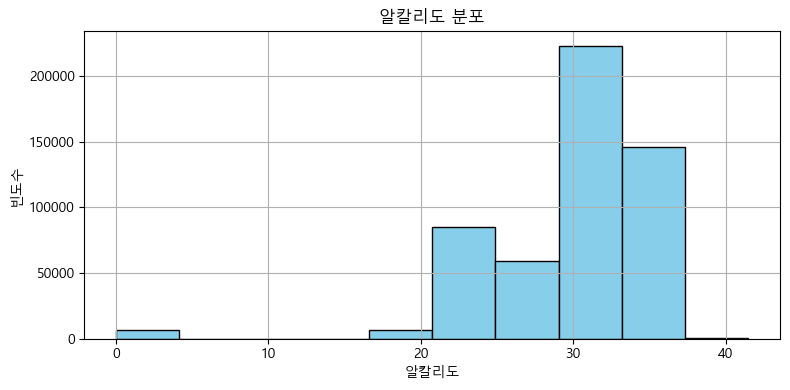

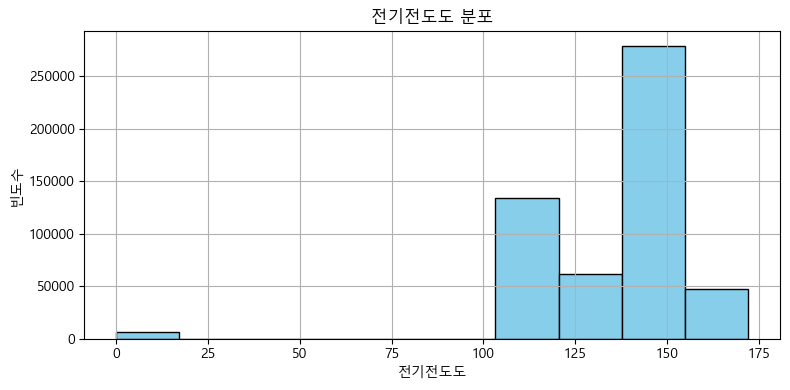

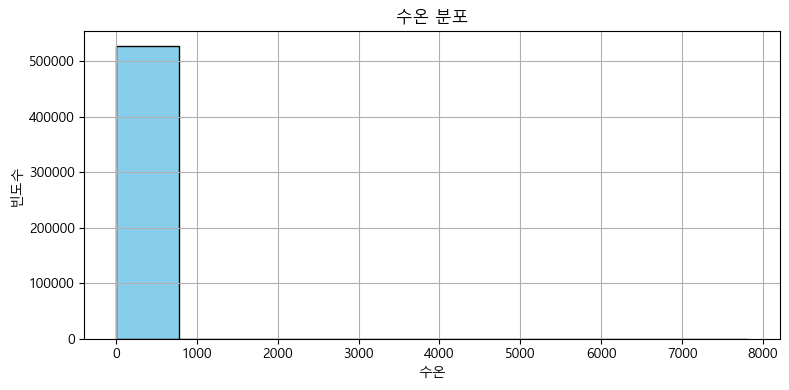

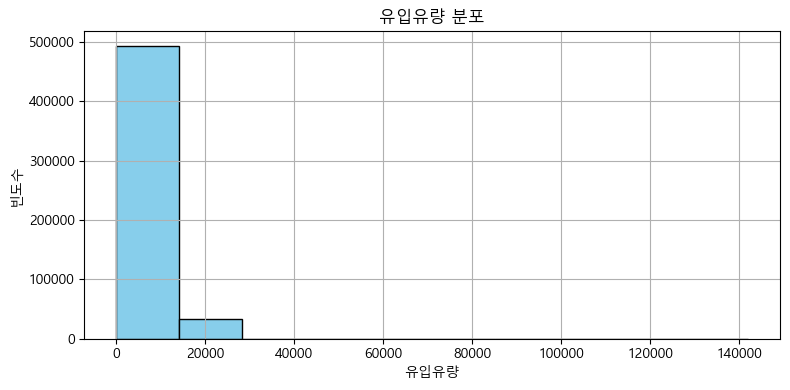

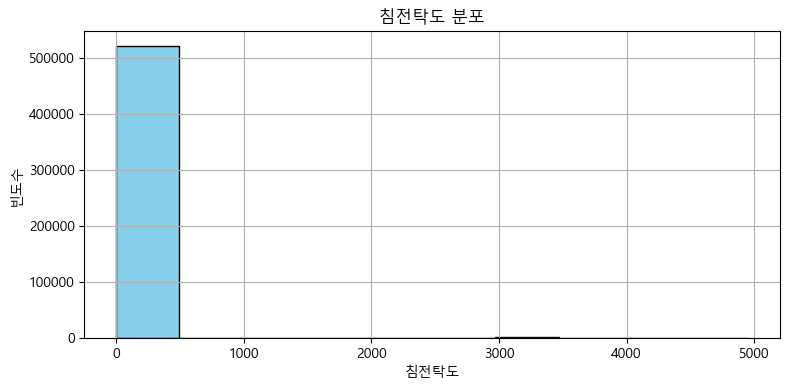

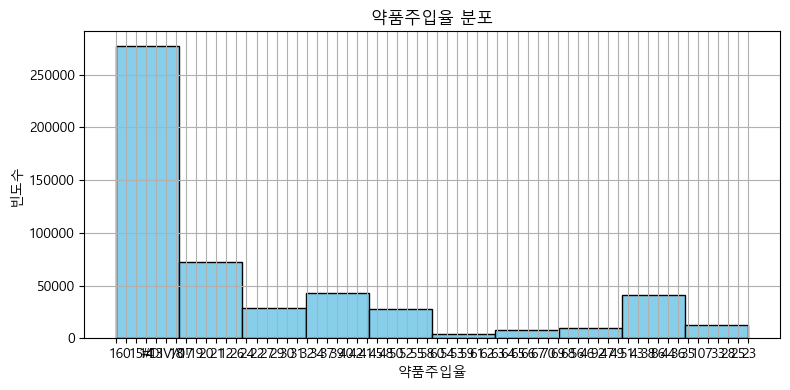

In [ ]:
for col in df.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 데이터 이상치 삭제

In [30]:
# 1. 모든 열에 대해 하나라도 0이 있으면 해당 행 삭제
df = df[(df != 0).all(axis=1)]

# 2. 조건에 맞는 이상치 제거
df = df[
    (df['탁도'] <= 500) &
    (df['pH'] >= 5) &
    (df['알칼리도'] >= 5) &
    (df['전기전도도'] >= 10) &
    (df['수온'] <= 50) &
    (df['유입유량'] >= 5000) & (df['유입유량'] <= 20000) &
    (df['침전탁도'] <= 1000)
]


In [31]:
df.describe()

,탁도,pH,알칼리도,전기전도도,수온,유입유량,침전탁도,약품주입율
count,513946.000000,513946.000000,513946.000000,513946.000000,513946.000000,513946.000000,513946.000000,513946.000000
mean,9.484611,7.301250,30.521930,138.567017,15.115918,12067.502197,0.755347,23.264991
std,12.813878,0.232712,4.153831,16.326327,5.920958,1354.458552,0.354912,13.910533
min,1.120000,6.170000,19.200000,10.060000,6.670000,7155.000000,0.010000,7.000000
25%,1.880000,7.110000,26.830000,119.630000,9.610000,11101.000000,0.490000,13.000000
50%,2.620000,7.360000,32.210000,146.410000,14.030000,11992.000000,0.690000,16.000000
75%,12.630000,7.460000,33.880000,153.470000,21.950000,13034.000000,0.990000,36.000000
max,90.580000,7.710000,41.490000,172.090000,25.350000,16631.000000,10.190000,92.000000


### 시각화하여 이상치 재확인

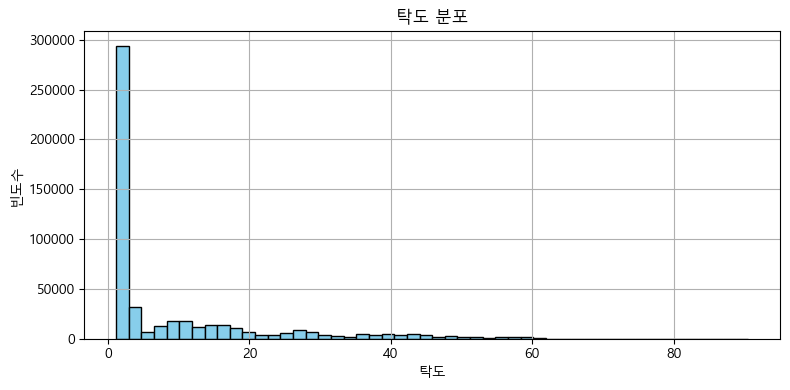

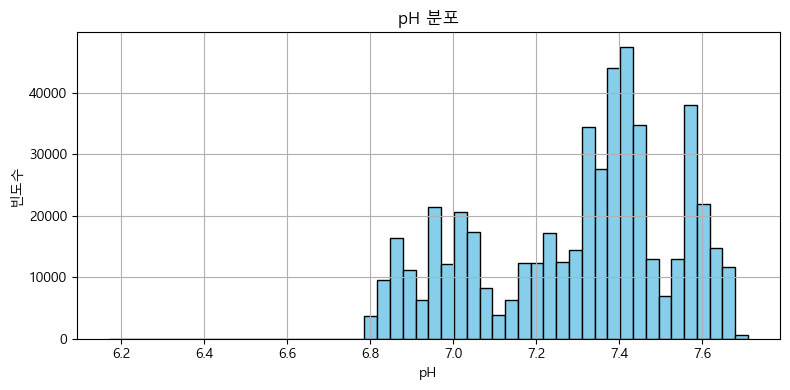

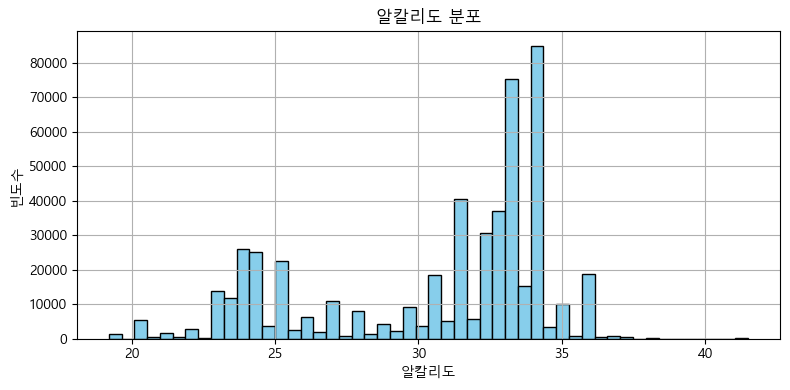

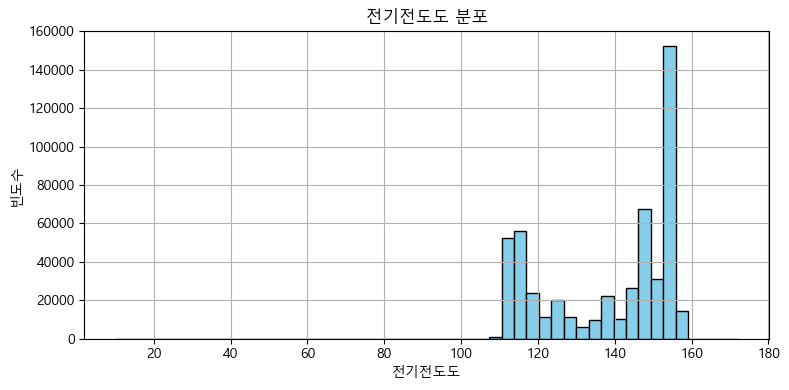

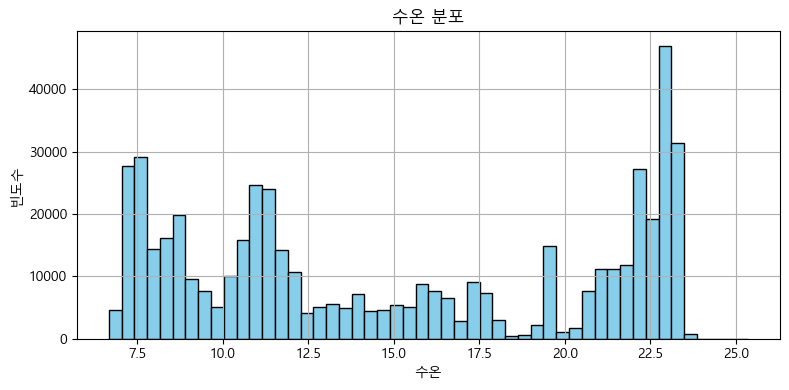

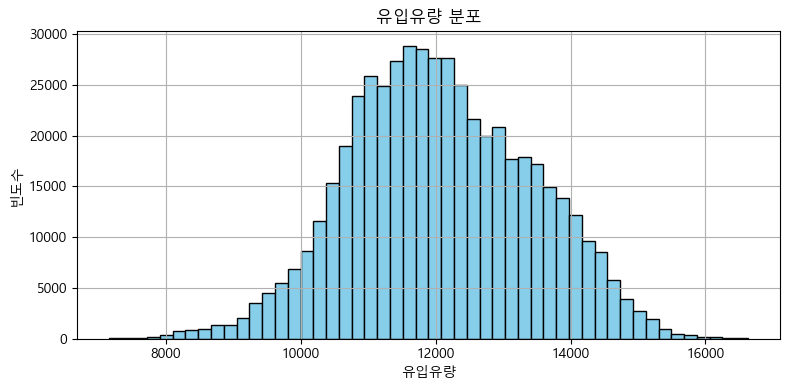

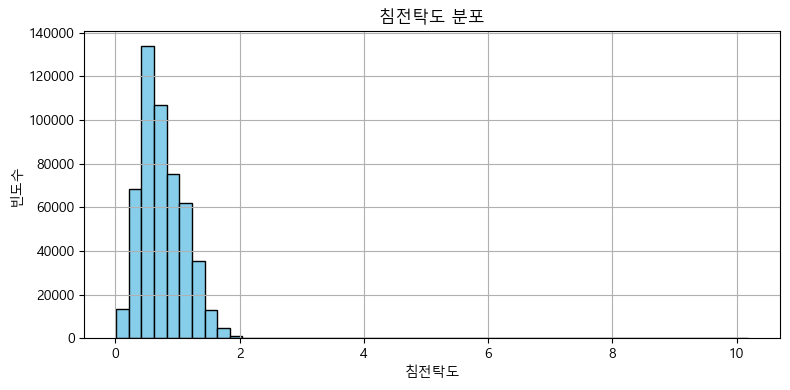

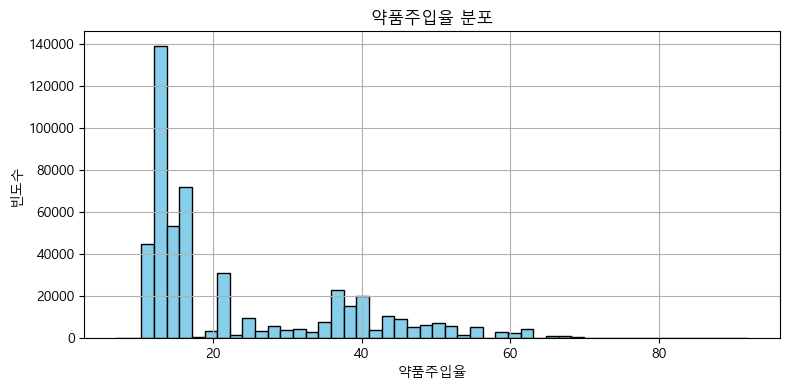

In [32]:
for col in df.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:

# # 탁도 분포에 따라 로그 변환 실행
# df['로그 탁도'] = np.log10(df["탁도"])


## 예측 함수

In [43]:
def run(target, input, max_depth, n_estimators, learning_rate, subsample):

    # Streamlit에서 사용하는 코드는 주석처리 후
    # 주피터 노트북 출력코드로 변경

    Xt, Xts, yt, yts = train_test_split(input, target, test_size=0.2, shuffle=False)

    xgb = XGBRegressor(
        random_state=2, 
        n_jobs=-1,
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample
    )

    xgb.fit(Xt, yt)
    
    yt_pred = xgb.predict(Xt)
    yts_pred = xgb.predict(Xts)

    mse_train = mean_squared_error(yt, yt_pred)
    mse_test = mean_squared_error(yts, yts_pred)

    # 로그스케일 데이터가 아니기 때문에 원래 값으로 비교
    # mse_train = mean_squared_error(10**yt, 10**yt_pred)
    # mse_test = mean_squared_error(10**yts, 10**yts_pred)
    # st.write(f"학습 데이터 MSE: {mse_train}")
    # st.write(f"테스트 데이터 MSE: {mse_test}")

    print(f"학습 데이터 MSE: {mse_train}")
    print(f"테스트 데이터 MSE: {mse_test}")

    r2_train = r2_score(yt, yt_pred)
    r2_test = r2_score(yts, yts_pred)
    # r2_train = r2_score(10**yt, 10**yt_pred)
    # r2_test = r2_score(10**yts, 10**yts_pred)
    # st.write(f"학습 데이터 R2: {r2_train}")
    # st.write(f"테스트 데이터 R2: {r2_test}")

    print(f"학습 데이터 R2: {r2_train}")
    print(f"테스트 데이터 R2: {r2_test}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax = axes[0]
    print(Xt.columns)
    ax.scatter(Xt.iloc[:, 0], yt, s=3, label="학습 데이터 (실제)")
    ax.scatter(Xt.iloc[:, 0], yt_pred, s=3, label="학습 데이터 (예측)", c="r")
    ax.grid()
    ax.legend(fontsize=13)
    
    ax.set_xlabel(input.columns[0])
    ax.set_ylabel(target.name)

    ax.set_title(
        rf"학습 데이터  MSE: {round(mse_train, 4)}, $R^2$: {round(r2_train, 2)}",
        fontsize=18,
    )

    ax = axes[1]
    # ax.scatter(Xt["로그 원수 탁도"], yt, s=3, label="학습 데이터 (실제)")
    # ax.scatter(Xt["로그 원수 탁도"], yt_pred, s=3, label="학습 데이터 (예측)", c="r")
    
    ax.scatter(Xt.iloc[:, 0], yt, s=3, label="학습 데이터 (실제)")
    ax.scatter(Xt.iloc[:, 0], yt_pred, s=3, label="학습 데이터 (예측)", c="r")

    ax.grid()
    ax.legend(fontsize=13)

    ax.set_xlabel(input.columns[0])
    ax.set_ylabel(target.name)

    ax.set_title(
        rf"테스트 데이터  MSE: {round(mse_test, 4)}, $R^2$: {round(r2_test, 2)}",
        fontsize=18,
    )

    # st.pyplot(fig)
    plt.show()

학습 데이터 MSE: 0.03079488550539294
테스트 데이터 MSE: 0.06405357824150497
학습 데이터 R2: 0.7932093491656926
테스트 데이터 R2: -1.1420648249506815
Index(['약품주입율', '탁도', 'pH', '수온'], dtype='object')


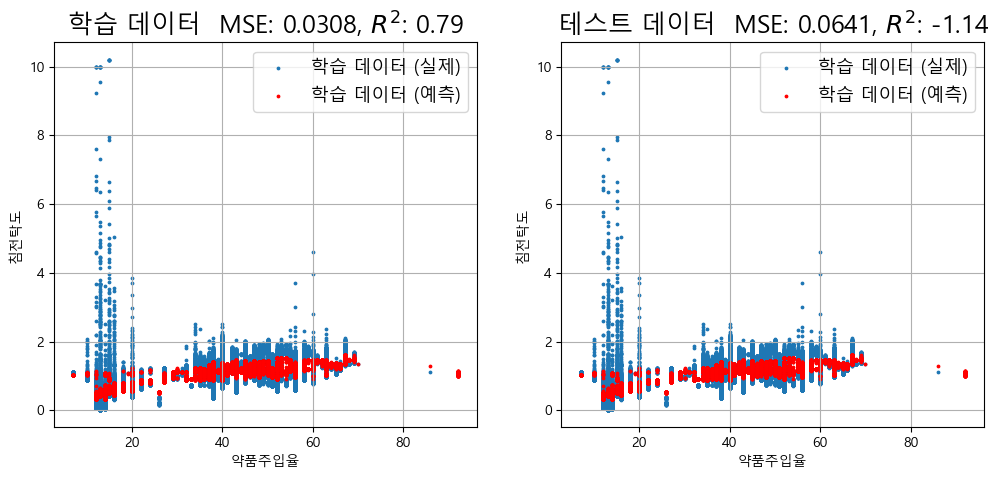

In [44]:
dff = df.copy()

col = dff['침전탁도']
filtered_col = dff[["약품주입율", "탁도", "pH", "수온"]]
max_depth = 3
n_estimators = 50
learning_rate = 0.1
subsample = 0.8

run(col, filtered_col, max_depth, n_estimators, learning_rate, subsample)

## 메인함수(streamlit에서 사용)

In [ ]:

def main():

    # load data
    # dff = load_data()
    dff = df.copy()

    # Select Variable
    st.markdown("타겟 변수는 침전탁도로 고정")
    column = "침전탁도"
    col = dff[[column]]
    st.dataframe(dff[[column]].head())

    st.markdown("## Select Input Variables")
    input_columns = st.multiselect("복수의 컬럼을 선택하세요.", dff.columns.tolist())
    filtered_col = dff[input_columns]

    st.dataframe(dff[input_columns].head())

    # Hyperparameters
    max_depth = st.slider("Select max depth", min_value=0, max_value=20, value=3)
    n_estimators = st.slider("n_estimators", min_value=20, max_value=500, value=50)
    learning_rate = st.slider("learning_rate", min_value=0.00, max_value=1.00, step=0.01, value=0.1)
    subsample = st.slider("subsample", min_value=0.00, max_value=1.00, step=0.01, value=0.8)

    if st.button("차트 만들기"):
        run(col, filtered_col, max_depth, n_estimators, learning_rate, subsample)
